# General properties and calculations
For Argon propellant

In [8]:
# Base imports
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from CoolProp.CoolProp import PropsSI
from scipy import constants
from conversions import *

# Custom packages
import IdealThrust as it
import saha

In [9]:
## Define and print some useful values
# R_UNIV = 8.31446261815324  # J mol^-1 K^-1, Universal gas constant
R_UNIV = constants.R

workingFluid = 'Argon'
standard_pressure = 101.3e3  # Pa, atmospheric pressure
standard_temperature = 273.15  # K, standard temperature (0C)
room_temperature = 300  # K, ambient temperature

gamma = PropsSI('isentropic_expansion_coefficient', 
    'P', standard_pressure, 
    'T', room_temperature, 
    workingFluid)
GAMMA = it.getGAMMA(gamma)
molarMass = PropsSI('M', workingFluid)

Rg = R_UNIV/molarMass

print('gamma =', gamma)
print('GAMMA =', GAMMA)
print('M =', molarMass, 'kg/mol')
print('Rg =', Rg, 'J/kg-K')

gamma = 1.6685069176090714
GAMMA = 0.7264478807262494
M = 0.039948 kg/mol
Rg = 208.13213722839694 J/kg-K


In [10]:
## Define some inputs
min_pc = 3e5  # Pa
max_pc = 20e5  # Pa
chamber_pressures = np.linspace(min_pc, max_pc)

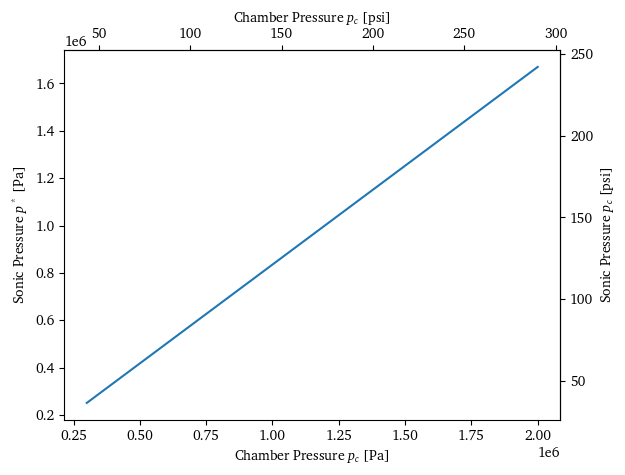

In [22]:
## Compute sonic conditions
sonic_pressures = chamber_pressures*(2/(gamma+1))**(gamma/(gamma+1))
plt.plot(chamber_pressures, sonic_pressures)
plt.xlabel('Chamber Pressure $p_c$ [Pa]')
plt.ylabel(r'Sonic Pressure $p^*$ [Pa]')
convertAxis('x', (Pa2psi, psi2Pa), 'Chamber Pressure $p_c$ [psi]')
convertAxis('y', (Pa2psi, psi2Pa), 'Sonic Pressure $p_c$ [psi]')
plt.show()

# Ideal Expansion
Most calculations will assume ideal expansion in the nozzle, i.e., matching pressure at the nozzle exit plane with no shocks, expansion fans, or flow separation. Given that the current design will always operate in ambient air, we can practically set the nozzle geometry to ensure ideal expansion. In such a case, the ideal thrust coefficent $C_F^\circ$ is the limit/target thrust coefficient, defined by:
$$
    C_F^\circ = \Gamma\sqrt{\frac{2\gamma}{\gamma-1}\left(1-\left(\frac{p_b}{p_0}\right)^{(\gamma-1)/\gamma}\right)}
$$

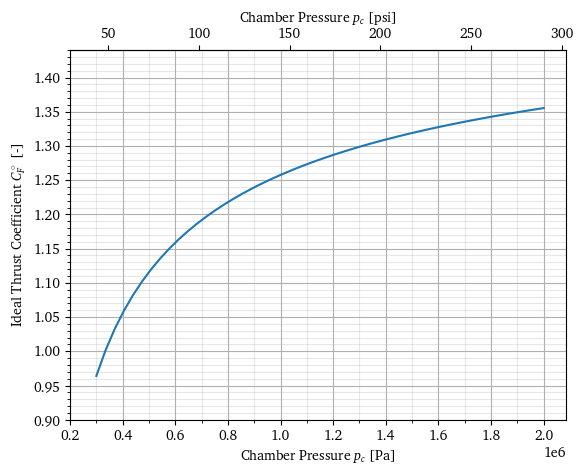

In [12]:
## Computing ideal expansion thrust factor
cf_ideal = it.cf_ideal(gamma, standard_pressure, chamber_pressures)

# Plotting
plt.plot(chamber_pressures, cf_ideal)
plt.xlabel('Chamber Pressure $p_c$ [Pa]')
plt.ylabel('Ideal Thrust Coefficient $C_F^\circ$ [-]')
plt.xticks(np.arange(min_pc-1e5, max_pc+1e5, 2e5))
plt.xticks(np.arange(min_pc, max_pc+1e5, 1e5), minor=True)
ylocs, ylab = plt.yticks()
ylocs_step = ylocs[1]-ylocs[0]
plt.yticks(np.arange(ylocs[0], ylocs[-1]+ylocs_step, ylocs_step))
plt.yticks(np.arange(ylocs[0], ylocs[-1]+ylocs_step, ylocs_step/5), minor=True)
plt.grid(which='major')
plt.grid(which='minor', alpha=0.3)
convertAxis('x', (Pa2psi, psi2Pa), 'Chamber Pressure $p_c$ [psi]')

plt.show()

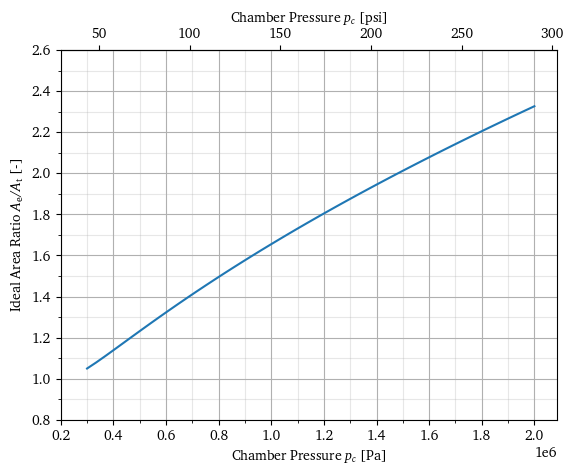

In [13]:
## Computing associated nozzle geometry
Aratio_ideal = it.Aratio_ideal(gamma, standard_pressure, chamber_pressures)

plt.plot(chamber_pressures, Aratio_ideal)
plt.xlabel('Chamber Pressure $p_c$ [Pa]')
plt.ylabel(r'Ideal Area Ratio $A_\mathrm{e}/A_\mathrm{t}$ [-]')
plt.xticks(np.arange(min_pc-1e5, max_pc+1e5, 2e5))
plt.xticks(np.arange(min_pc, max_pc+1e5, 1e5), minor=True)
ylocs, ylab = plt.yticks()
ylocs_step = ylocs[1]-ylocs[0]
plt.yticks(np.arange(ylocs[0], ylocs[-1]+ylocs_step, ylocs_step))
plt.yticks(np.arange(ylocs[0], ylocs[-1]+ylocs_step, ylocs_step/2), minor=True)
plt.grid(which='major')
plt.grid(which='minor', alpha=0.3)
convertAxis('x', (Pa2psi, psi2Pa), 'Chamber Pressure $p_c$ [psi]')

plt.show()

# Defining an operational range
To guide our design, we have to determine an operational range in terms of pressure, flow speed and input power. These will determine chamber and nozzle geometry. To begin, by assuming $C_F = C_F^\circ$, we can compute a throat area based on the desired chamber pressure and thrust of the engine:
$$
    C_F^\circ = C_F = \frac{F_\mathrm{T}}{p_0A_t} \implies A_t = \frac{F_\mathrm{T}}{p_0C_F^\circ}
$$

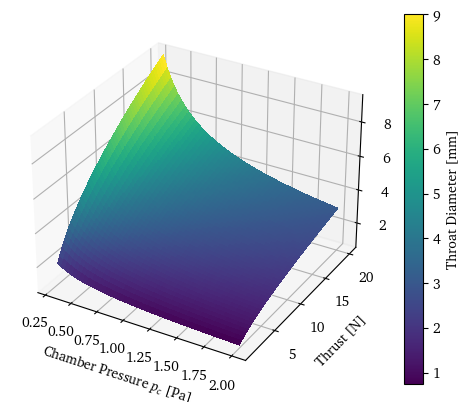

In [21]:
# Chamber pressure/thrust effect on throat diameter, assuming ideal exp
desired_thrust = np.linspace(1,20)  # N
CHAMBER_PRESSURES, THRUSTS = np.meshgrid(chamber_pressures, desired_thrust)
THROAT_AREA = (CHAMBER_PRESSURES 
               * it.cf_ideal(gamma, standard_pressure, CHAMBER_PRESSURES)
               / THRUSTS)**-1
THROAT_DIAMETER = np.sqrt(4*THROAT_AREA/np.pi)
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(CHAMBER_PRESSURES, THRUSTS, THROAT_DIAMETER*1000,
                       cmap=matplotlib.cm.viridis, linewidth=0, 
                       antialiased=False)
ax.set_xlabel('Chamber Pressure $p_c$ [Pa]')
ax.set_ylabel('Thrust [N]')
fig.colorbar(surf, label='Throat Diameter [mm]')
plt.show()

Then we feed this to the choked mass flow rate equation:
$$
    \dot{m} = K_{\dot{m}}A_t\frac{p_0}{\sqrt{T_0}} = K_{\dot{m}}A_t\frac{p_0}{\sqrt{T(\Delta h)}}
$$

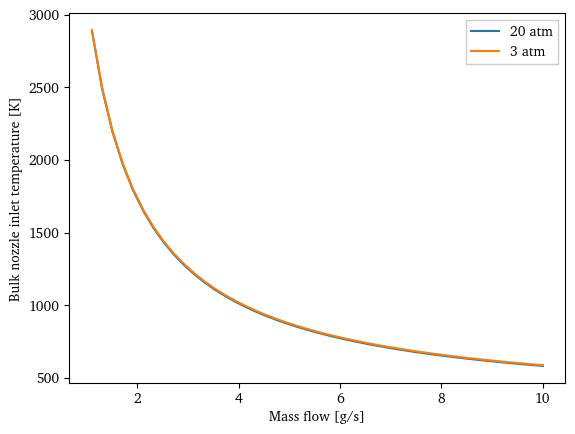

In [28]:
mdot = np.linspace(0.1,10)*1e-3  # kg/s
h0_high = PropsSI('H', 'T', room_temperature, 'P', 20*1e5, workingFluid)
h0_low = PropsSI('H', 'T', room_temperature, 'P', 3*1e5, workingFluid)
T0_high = PropsSI('T', 'P', 20*1e5, 'H', h0_high+(0.5*3000)/mdot, workingFluid)
T0_low = PropsSI('T', 'P', 3*1e5, 'H', h0_low+(0.5*3000)/mdot, workingFluid)
plt.plot(mdot*1000, T0_high, label='20 atm')
plt.plot(mdot*1000, T0_low, label='3 atm')
plt.legend()
plt.xlabel('Mass flow [g/s]')
plt.ylabel('Bulk nozzle inlet temperature [K]')
plt.show()